In [1]:
import numpy, scipy, matplotlib.pyplot as plt, pandas as pd
import sklearn, IPython.display as ipd
import librosa, librosa.display

from sklearn.metrics import *
from pathlib import Path
%matplotlib inline

## Step 1: Retrieve Audio

In [2]:
c1_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c1/*.mp3')
]
c2_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c2/*.mp3')
]

In [3]:
print(len(c1_signals))
print(len(c2_signals))

100
100


## Step 2: Extract Features

In [4]:
n_mfcc = 12
hop_length = 512
def extract_features(signal):
    zcr = librosa.feature.zero_crossing_rate(signal).mean()
    cent = librosa.feature.spectral_centroid(signal).mean()
    mfccs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc).mean()
    S = librosa.feature.melspectrogram(signal).mean()
    tempo = librosa.feature.tempogram(signal, hop_length=hop_length).mean()
    rmse = librosa.feature.rmse(signal, hop_length=hop_length).mean()
    chroma = librosa.feature.chroma_stft(signal).mean()
    spec_bw = librosa.feature.spectral_bandwidth(signal).mean()
    return [zcr, cent, mfccs, S, tempo, rmse, chroma, spec_bw]

In [5]:
c1_features = numpy.array([extract_features(x) for x in c1_signals])
c2_features = numpy.array([extract_features(x) for x in c2_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [6]:
print(c1_features.shape)
print(c2_features.shape)

(100, 8)
(100, 8)


## Step 3: Train the Classifier

In [7]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))

c1_features_scaled = scaler.fit_transform(c1_features)
print(c1_features_scaled.mean(axis=0))
print(c1_features_scaled.std(axis=0))

c2_features_scaled = scaler.transform(c2_features)
print(c2_features_scaled.mean(axis=0))
print(c2_features_scaled.std(axis=0))

[-0.23336744 -0.08948801  0.12649063 -0.51290256 -0.15395375 -0.21921891
 -0.27510573 -0.09310684]
[0.46218705 0.38335149 0.46212865 0.37861044 0.43241216 0.38094568
 0.35045076 0.35457033]
[-0.36488162  0.16760711  0.11460639 -0.72234962 -0.07585366 -0.52252048
 -0.01492442  0.48434216]
[0.57286357 0.505123   0.56765696 0.28821355 0.53063895 0.32892931
 0.43578074 0.32568216]


In [8]:
train_features = numpy.vstack((c1_features_scaled, c2_features_scaled))
print(train_features.shape)
print(train_features.min(axis=0))
print(train_features.max(axis=0))

(200, 8)
[-1.32854262 -1.         -1.35085151 -1.01270722 -1.         -1.07418495
 -1.         -1.        ]
[1.5849273  1.81745481 1.         1.         1.30479156 1.
 1.04283688 1.09160228]


In [9]:
train_labels = numpy.concatenate((numpy.zeros(len(c1_features_scaled)), numpy.ones(len(c2_features_scaled))))

In [10]:
print(train_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [12]:
acc  = sklearn.model_selection.cross_val_score(model, train_features, train_labels, cv=10)

In [13]:
print('acc =', acc)
print ('acc mean =',acc.mean())

acc = [1.   0.95 0.9  0.75 0.9  0.95 0.85 0.95 0.75 0.9 ]
acc mean = 0.89


In [14]:
model.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

## Step 4: Run the Classifier

In [15]:
c1_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c1/*.mp3')
]
c2_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c2/*.mp3')
]

In [16]:
print(len(c1_test_signals))
print(len(c2_test_signals))

25
25


In [17]:
c1_test_features = numpy.array([extract_features(x) for x in c1_test_signals])
c2_test_features = numpy.array([extract_features(x) for x in c2_test_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [18]:
print(c1_test_features.shape)
print(c2_test_features.shape)

(25, 8)
(25, 8)


In [19]:
c1_test_features_scaled = scaler.transform(c1_test_features)
c2_test_features_scaled = scaler.transform(c2_test_features)

In [20]:
test_features = numpy.vstack((c1_test_features_scaled, c2_test_features_scaled))

In [21]:
test_labels = numpy.concatenate((numpy.zeros(len(c1_test_features)), numpy.ones(len(c2_test_features))))

In [22]:
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [23]:
predicted_labels = model.predict(test_features)

In [24]:
print(predicted_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1.]


## Step 5: Evaluation

### Classification Metrics

In [25]:
score = model.score(test_features, test_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
roc_auc = roc_auc_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
fmeasure = f1_score(test_labels, predicted_labels)
cohen_kappa = cohen_kappa_score(test_labels, predicted_labels)

In [26]:
tp = sum((test_labels == 1) & (predicted_labels == 1))
tn = sum((test_labels == 0) & (predicted_labels == 0))
fp = sum((test_labels == 0) & (predicted_labels == 1))
fn = sum((test_labels == 1) & (predicted_labels == 0))
print (tp, tn, fp, fn)

19 21 4 6


In [27]:
classification_metrics = [score, accuracy, roc_auc, recall, precision, fmeasure, cohen_kappa]
classification_metrics_labels = ['score', 'accuracy', 'roc_auc', 'recall', 'precision', 'fmeasure', 'cohen_kappa']

In [28]:
pd.DataFrame(classification_metrics, classification_metrics_labels)

,0
score,0.800000
accuracy,0.800000
roc_auc,0.800000
recall,0.760000
precision,0.826087
fmeasure,0.791667
cohen_kappa,0.600000


### Plot ROC Curve

In [29]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, predicted_labels)
roc_auc = auc(false_positive_rate, true_positive_rate)

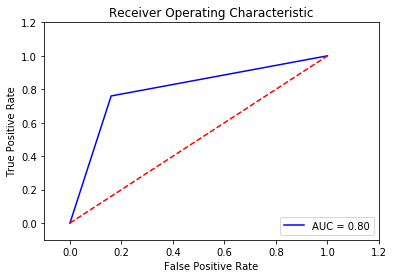

In [30]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()